In [3]:
from google.colab import files
uploaded = files.upload()

Saving b517dfd59d2c5bd69e313ad17dc6ee4b.zip to b517dfd59d2c5bd69e313ad17dc6ee4b.zip


In [4]:
!pip install xarray rioxarray netCDF4 rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.1 MB/s eta 0:00:00


In [5]:
import zipfile
import os

# Get the uploaded file name
zip_filename = list(uploaded.keys())[0]

# Create extraction folder
extract_dir = "weather_data"
os.makedirs(extract_dir, exist_ok=True)

# Extract contents
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted to '{extract_dir}/'")

✅ Extracted to 'weather_data/'


In [6]:
# List extracted files
for file in os.listdir(extract_dir):
    print(file)

data_stream-oper_stepType-instant.nc
data_stream-oper_stepType-accum.nc


In [7]:
import xarray as xr

ds_instant = xr.open_dataset("weather_data/data_stream-oper_stepType-instant.nc")
ds_accum = xr.open_dataset("weather_data/data_stream-oper_stepType-accum.nc")

In [8]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import os

# Load both datasets
ds_instant = xr.open_dataset("weather_data/data_stream-oper_stepType-instant.nc")
ds_accum = xr.open_dataset("weather_data/data_stream-oper_stepType-accum.nc")

output_dir = "geotiffs"
os.makedirs(output_dir, exist_ok=True)

# Variable: (dataset, output_name)
var_sources = {
    't2m': (ds_instant, 'temperature'),
    'u10': (ds_instant, 'u_wind'),
    'v10': (ds_instant, 'v_wind'),
    'd2m': (ds_instant, 'dewpoint'),
    'tp':  (ds_accum, 'precipitation'),
}

for var, (src, out_name) in var_sources.items():
    da = src[var].isel(valid_time=0)  # ✅ Fix here
    da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    da.rio.write_crs("EPSG:4326", inplace=True)
    da.rio.to_raster(f"{output_dir}/{out_name}.tif")
    print(f"✅ Saved: {output_dir}/{out_name}.tif")

✅ Saved: geotiffs/temperature.tif
✅ Saved: geotiffs/u_wind.tif
✅ Saved: geotiffs/v_wind.tif
✅ Saved: geotiffs/dewpoint.tif
✅ Saved: geotiffs/precipitation.tif


In [9]:
from google.colab import files
uploaded = files.upload()  # Select all your downloaded `.tif` files

Saving P5_PAN_CD_N28_000_E079_000_DEM_30m.tif to P5_PAN_CD_N28_000_E079_000_DEM_30m.tif
Saving P5_PAN_CD_N28_000_E080_000_DEM_30m.tif to P5_PAN_CD_N28_000_E080_000_DEM_30m.tif
Saving P5_PAN_CD_N29_000_E077_000_DEM_30m.tif to P5_PAN_CD_N29_000_E077_000_DEM_30m.tif
Saving P5_PAN_CD_N29_000_E078_000_DEM_30m.tif to P5_PAN_CD_N29_000_E078_000_DEM_30m.tif
Saving P5_PAN_CD_N29_000_E079_000_DEM_30m.tif to P5_PAN_CD_N29_000_E079_000_DEM_30m.tif
Saving P5_PAN_CD_N29_000_E080_000_DEM_30m.tif to P5_PAN_CD_N29_000_E080_000_DEM_30m.tif
Saving P5_PAN_CD_N30_000_E077_000_DEM_30m.tif to P5_PAN_CD_N30_000_E077_000_DEM_30m.tif
Saving P5_PAN_CD_N30_000_E078_000_DEM_30m.tif to P5_PAN_CD_N30_000_E078_000_DEM_30m.tif
Saving P5_PAN_CD_N30_000_E079_000_DEM_30m.tif to P5_PAN_CD_N30_000_E079_000_DEM_30m.tif
Saving P5_PAN_CD_N30_000_E080_000_DEM_30m.tif to P5_PAN_CD_N30_000_E080_000_DEM_30m.tif
Saving P5_PAN_CD_N30_000_E081_000_DEM_30m.tif to P5_PAN_CD_N30_000_E081_000_DEM_30m.tif
Saving P5_PAN_CD_N31_000_E077_00

In [10]:
import rasterio
from rasterio.merge import merge
import os
import glob

# Save all uploaded files temporarily
os.makedirs("dem_tiles", exist_ok=True)
for fname in uploaded.keys():
    os.rename(fname, f"dem_tiles/{fname}")

# Merge all .tif files in dem_tiles
tif_files = glob.glob("dem_tiles/*.tif")
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]

mosaic, out_trans = merge(src_files_to_mosaic)

# Save merged DEM
merged_path = "uttarakhand_dem_30m.tif"
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": src_files_to_mosaic[0].crs
})

with rasterio.open(merged_path, "w", **out_meta) as dest:
    dest.write(mosaic)

print("✅ Merged DEM saved as:", merged_path)

✅ Merged DEM saved as: uttarakhand_dem_30m.tif


In [11]:
from osgeo import gdal

# Generate slope
gdal.DEMProcessing("geotiffs/slope.tif", merged_path, "slope", computeEdges=True)

# Generate aspect
gdal.DEMProcessing("geotiffs/aspect.tif", merged_path, "aspect", computeEdges=True)

print("✅ Slope and aspect saved to 'geotiffs/'")

/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


✅ Slope and aspect saved to 'geotiffs/'


In [12]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Set temperature.tif as reference
ref_path = "geotiffs/temperature.tif"
ref_raster = rasterio.open(ref_path)
ref_meta = ref_raster.meta
ref_shape = (ref_meta['height'], ref_meta['width'])

# Paths to all rasters to be aligned
raster_files = [
    "geotiffs/temperature.tif",
    "geotiffs/dewpoint.tif",
    "geotiffs/u_wind.tif",
    "geotiffs/v_wind.tif",
    "geotiffs/precipitation.tif",
    "geotiffs/slope.tif",
    "geotiffs/aspect.tif"
]

aligned_arrays = []

for path in raster_files:
    with rasterio.open(path) as src:
        # Resample to match reference raster
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.bilinear
        )[0]
        aligned_arrays.append(data.astype(np.float32))

# Now all arrays have same shape
feature_stack = np.stack(aligned_arrays, axis=-1)

print("✅ Feature stack created:", feature_stack.shape)

✅ Feature stack created: (15, 17, 7)


In [13]:
np.save("feature_stack.npy", feature_stack)

In [14]:
from google.colab import files
uploaded = files.upload()

Saving fire_archive_SV-C2_628973.csv to fire_archive_SV-C2_628973.csv


In [15]:
import pandas as pd
import os

# Get uploaded CSV filename
fire_csv = list(uploaded.keys())[0]
print("✅ Uploaded:", fire_csv)

# Load the fire data
df = pd.read_csv(fire_csv)

# Check column names (just to be sure)
print(df.columns)

✅ Uploaded: fire_archive_SV-C2_628973.csv
Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')


In [16]:
import pandas as pd

df = pd.read_csv("fire_archive_SV-C2_628973.csv")

# Convert confidence: 'l', 'n', 'h' ➝ 30, 60, 90
conf_map = {'l': 30, 'n': 60, 'h': 90}
df['confidence_score'] = df['confidence'].str.lower().map(conf_map)

# Drop invalid rows
df = df.dropna(subset=['latitude', 'longitude', 'confidence_score'])

print("✅ Fire points with valid confidence:", len(df))

✅ Fire points with valid confidence: 86193


In [17]:
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# Filter high-confidence fires only
df = df[df['confidence_score'] >= 80]

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Use temperature.tif as reference
with rasterio.open("geotiffs/temperature.tif") as ref:
    height = ref.height
    width = ref.width
    crs = ref.crs
    transform = ref.transform

# Project fire points to raster CRS
gdf = gdf.to_crs(crs)

# Rasterize: 1 for fire, 0 for background
shapes = ((geom, 1) for geom in gdf.geometry)
fire_mask = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

np.save("label_mask.npy", fire_mask)

print("✅ Fire label mask saved as 'label_mask.npy'")
print("🔥 Fire pixels found:", np.sum(fire_mask))

✅ Fire label mask saved as 'label_mask.npy'
🔥 Fire pixels found: 26


In [18]:
from google.colab import files
uploaded = files.upload()

Saving ISRO DATASET.0.tif to ISRO DATASET.0.tif


In [19]:
import rasterio
import numpy as np

lulc_path = list(uploaded.keys())[0]  # your uploaded LULC file

# Open and read
with rasterio.open(lulc_path) as src:
    lulc = src.read(1)
    meta = src.meta

# Reclassify based on LULC class codes
fuel = np.zeros_like(lulc, dtype=np.float32)
fuel[lulc == 1] = 1.0
fuel[lulc == 2] = 0.8
fuel[lulc == 3] = 0.6
fuel[lulc == 4] = 0.4
fuel[lulc == 5] = 0.2
fuel[(lulc >= 6)] = 0.0  # everything else

np.save("fuel_availability.npy", fuel)
print("✅ Saved: fuel_availability.npy")

✅ Saved: fuel_availability.npy


In [20]:
from rasterio.enums import Resampling

# Match with temperature raster
with rasterio.open(lulc_path) as src, rasterio.open("geotiffs/temperature.tif") as ref:
    fuel_resampled = src.read(
        1,  # Band index 1 (first band)
        out_shape=(ref.height, ref.width),
        resampling=Resampling.nearest
    )

# Reclassify again (same as above)
fuel = np.zeros_like(fuel_resampled, dtype=np.float32)
fuel[fuel_resampled == 1] = 1.0
fuel[fuel_resampled == 2] = 0.8
fuel[fuel_resampled == 3] = 0.6
fuel[fuel_resampled == 4] = 0.4
fuel[fuel_resampled == 5] = 0.2
fuel[(fuel_resampled >= 6)] = 0.0

np.save("fuel_availability.npy", fuel)
print("✅ Resampled & saved: fuel_availability.npy")

✅ Resampled & saved: fuel_availability.npy


In [21]:
import numpy as np

# Load previous stack and new fuel layer
features = np.load("feature_stack.npy")             # shape: (H, W, 7)
fuel = np.load("fuel_availability.npy")             # shape: (H, W)

# Add fuel as the 8th channel
features = np.concatenate([features, fuel[..., None]], axis=-1)

# Save updated feature stack
np.save("feature_stack_with_fuel.npy", features)
print("✅ New feature stack shape:", features.shape)

✅ New feature stack shape: (15, 17, 8)


In [22]:
import numpy as np

X = np.load("feature_stack_with_fuel.npy")  # shape should be (H, W, 8)
y = np.load("label_mask.npy")               # shape should be (H, W)

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)

# Optional: Count fire pixels
print("🔥 Fire pixels in y:", np.sum(y))

✅ X shape: (15, 17, 8)
✅ y shape: (15, 17)
🔥 Fire pixels in y: 26


In [23]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 780.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.9 MB/s eta 0:00:00


In [24]:
import numpy as np

def pad_to_square(img, target_size=64):
    h, w = img.shape[:2]
    pad_h = target_size - h
    pad_w = target_size - w
    if img.ndim == 2:
        pad = ((0, pad_h), (0, pad_w))
    else:
        pad = ((0, pad_h), (0, pad_w), (0, 0))
    return np.pad(img, pad, mode='constant', constant_values=0)

# Load and pad
X = np.load("feature_stack_with_fuel.npy")
y = np.load("label_mask.npy")

X = pad_to_square(X, 64)  # shape: (64, 64, 8)
y = pad_to_square(y, 64)  # shape: (64, 64)

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

class FullImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.transpose(2, 0, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.X, self.y

dataset = FullImageDataset(X, y)
loader = DataLoader(dataset, batch_size=1)

In [26]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=8,
    classes=2
).to("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=8,
    classes=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [28]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f"✅ Epoch {epoch+1}: Loss = {loss.item():.4f}")

✅ Epoch 1: Loss = 0.7355
✅ Epoch 2: Loss = 0.6417
✅ Epoch 3: Loss = 0.5453
✅ Epoch 4: Loss = 0.4576
✅ Epoch 5: Loss = 0.3880
✅ Epoch 6: Loss = 0.3367
✅ Epoch 7: Loss = 0.2985
✅ Epoch 8: Loss = 0.2661
✅ Epoch 9: Loss = 0.2363
✅ Epoch 10: Loss = 0.2101


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


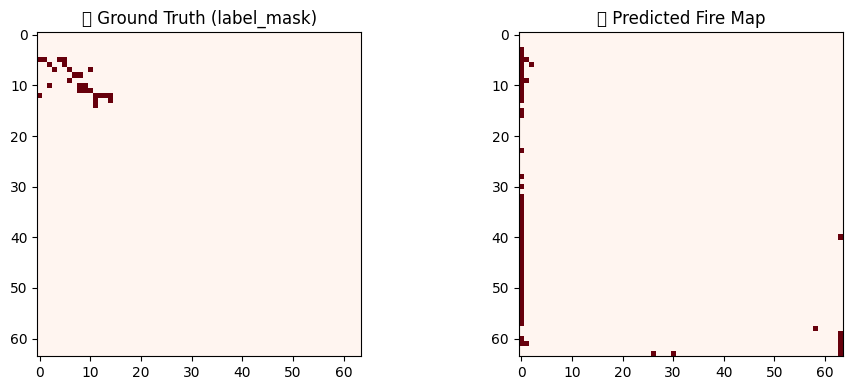

In [29]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    pred = model(x_batch.to(device))
    pred_class = torch.argmax(F.softmax(pred, dim=1), dim=1).squeeze().cpu().numpy()

# Plot ground truth vs prediction
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(y, cmap='Reds')
axs[0].set_title("🔥 Ground Truth (label_mask)")
axs[1].imshow(pred_class, cmap='Reds')
axs[1].set_title("🤖 Predicted Fire Map")
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Flatten arrays
y_true = y.flatten()
y_pred = pred_class.flatten()

print("✅ Fire pixels in ground truth:", np.sum(y_true))
print("🔥 Fire pixels in prediction  :", np.sum(y_pred))

# Metrics
print("\n📊 Evaluation Metrics:")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score :", f1_score(y_true, y_pred, zero_division=0))
print("IoU      :", jaccard_score(y_true, y_pred, zero_division=0))

✅ Fire pixels in ground truth: 26
🔥 Fire pixels in prediction  : 57

📊 Evaluation Metrics:
Accuracy : 0.981689453125
Precision: 0.07017543859649122
Recall   : 0.15384615384615385
F1 Score : 0.0963855421686747
IoU      : 0.05063291139240506


In [31]:
# Save model weights
torch.save(model.state_dict(), "unet_fire_model.pth")
print("✅ Model saved as unet_fire_model.pth")

✅ Model saved as unet_fire_model.pth


In [32]:
from google.colab import files
uploaded = files.upload()

Saving GHS_BUILT_S_E2015_GLOBE_R2023A_54009_100_V1_0_R6_C26.tif to GHS_BUILT_S_E2015_GLOBE_R2023A_54009_100_V1_0_R6_C26 (1).tif


In [33]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

ghsl_path = list(uploaded.keys())[0]  # your uploaded file
ref_path = "geotiffs/temperature.tif"  # or any raster already aligned

with rasterio.open(ghsl_path) as src, rasterio.open(ref_path) as ref:
    ghsl_resampled = src.read(
        1,
        out_shape=(ref.height, ref.width),
        resampling=Resampling.bilinear
    )

# Normalize built-up values to [0, 1]
ghsl_normalized = (ghsl_resampled - ghsl_resampled.min()) / (ghsl_resampled.max() - ghsl_resampled.min())
ghsl_normalized = np.nan_to_num(ghsl_normalized)

np.save("human_settlement_pressure.npy", ghsl_normalized)
print("✅ GHSL resampled, normalized, and saved.")

✅ GHSL resampled, normalized, and saved.


In [34]:
X = np.load("feature_stack_with_fuel.npy")                  # (15, 17, 8)
ghsl = np.load("human_settlement_pressure.npy")             # (15, 17)

# Stack GHSL as 9th channel
X_with_ghsl = np.concatenate([X, ghsl[..., None]], axis=-1)  # (15, 17, 9)
np.save("feature_stack_with_ghsl.npy", X_with_ghsl)
print("✅ New feature stack shape:", X_with_ghsl.shape)

✅ New feature stack shape: (15, 17, 9)


In [36]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=9,   # Now includes GHSL
    classes=2
).to(device)

In [37]:
import numpy as np

X = np.load("feature_stack_with_ghsl.npy")   # (15, 17, 9)
y = np.load("label_mask.npy")                # (15, 17)

# Normalize
X = (X - X.mean()) / (X.std() + 1e-6)
X = np.nan_to_num(X)

In [38]:
def pad_to_square(img, target_size=64):
    h, w = img.shape[:2]
    pad_h = target_size - h
    pad_w = target_size - w
    if img.ndim == 2:
        pad = ((0, pad_h), (0, pad_w))
    else:
        pad = ((0, pad_h), (0, pad_w), (0, 0))
    return np.pad(img, pad, mode='constant', constant_values=0)

X = pad_to_square(X, 64)  # (64, 64, 9)
y = pad_to_square(y, 64)  # (64, 64)

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

class FullImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.transpose(2, 0, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.X, self.y

dataset = FullImageDataset(X, y)
loader = DataLoader(dataset, batch_size=1)

In [40]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f"✅ Epoch {epoch+1}: Loss = {loss.item():.4f}")

✅ Epoch 1: Loss = 0.5491
✅ Epoch 2: Loss = 0.4483
✅ Epoch 3: Loss = 0.3488
✅ Epoch 4: Loss = 0.2774
✅ Epoch 5: Loss = 0.2292
✅ Epoch 6: Loss = 0.1985
✅ Epoch 7: Loss = 0.1737
✅ Epoch 8: Loss = 0.1536
✅ Epoch 9: Loss = 0.1370
✅ Epoch 10: Loss = 0.1231


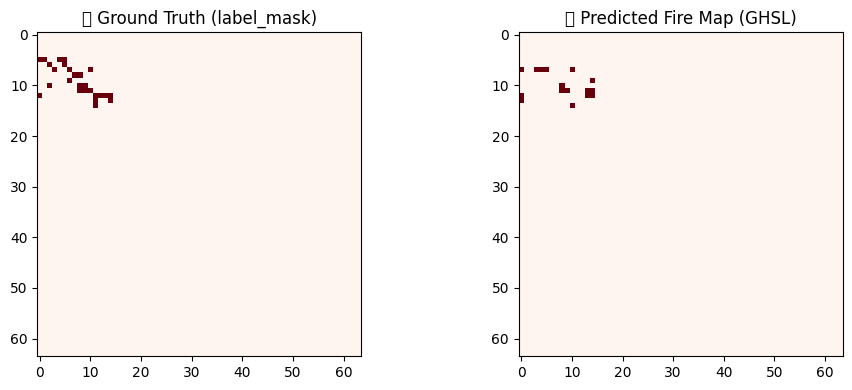

In [41]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    pred = model(x_batch.to(device))
    pred_class = torch.argmax(F.softmax(pred, dim=1), dim=1).squeeze().cpu().numpy()

# Plot GT vs prediction
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(y, cmap='Reds')
axs[0].set_title("🔥 Ground Truth (label_mask)")
axs[1].imshow(pred_class, cmap='Reds')
axs[1].set_title("🤖 Predicted Fire Map (GHSL)")
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

y_true = y.flatten()
y_pred = pred_class.flatten()

print("\n📊 GHSL-Enhanced Metrics:")
print("✅ Fire pixels in GT     :", np.sum(y_true))
print("🔥 Fire pixels predicted :", np.sum(y_pred))
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score :", f1_score(y_true, y_pred, zero_division=0))
print("IoU      :", jaccard_score(y_true, y_pred, zero_division=0))


📊 GHSL-Enhanced Metrics:
✅ Fire pixels in GT     : 26
🔥 Fire pixels predicted : 16
Accuracy : 0.99365234375
Precision: 0.5
Recall   : 0.3076923076923077
F1 Score : 0.38095238095238093
IoU      : 0.23529411764705882


In [43]:
torch.save(model.state_dict(), "unet_fire_model_with_ghsl.pth")

In [45]:
import rasterio

with rasterio.open("geotiffs/temperature.tif") as ref:
    profile = ref.profile
    profile.update(dtype='uint8', count=1, nodata=0)  # ✅ Fix here

    with rasterio.open("predicted_fire_map_GHSL.tif", 'w', **profile) as dst:
        dst.write(pred_class.astype('uint8'), 1)

print("✅ Saved: predicted_fire_map_GHSL.tif")

✅ Saved: predicted_fire_map_GHSL.tif


In [68]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

def resample_to_match(input_tif, reference_tif):
    with rasterio.open(input_tif) as src, rasterio.open(reference_tif) as ref:
        data = src.read(
            1,
            out_shape=(ref.height, ref.width),
            resampling=Resampling.bilinear
        )
        print(f"✅ Resampled: {input_tif} → shape {data.shape}")
        return data

# Resample wind to match temperature.tif shape
u_res = resample_to_match("geotiffs/u_wind.tif", "geotiffs/temperature.tif")
v_res = resample_to_match("geotiffs/v_wind.tif", "geotiffs/temperature.tif")

✅ Resampled: geotiffs/u_wind.tif → shape (15, 17)
✅ Resampled: geotiffs/v_wind.tif → shape (15, 17)


In [70]:
def pad_to_square(img, target_size=64):
    h, w = img.shape[:2]
    pad_h = max(0, target_size - h)
    pad_w = max(0, target_size - w)
    padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    print(f"📦 Padded to: {padded.shape}")
    return padded

# Load slope & fuel
slope = resample_to_match("geotiffs/slope.tif", "geotiffs/temperature.tif")
fuel = np.load("fuel_availability.npy")

# Pad everything to 64x64
slope_padded = pad_to_square(slope, 64)
fuel_padded = pad_to_square(fuel, 64)
u_padded = pad_to_square(u_res, 64)
v_padded = pad_to_square(v_res, 64)
fire_padded = pad_to_square(pred_class, 64)  # from your U-Net prediction

✅ Resampled: geotiffs/slope.tif → shape (15, 17)
📦 Padded to: (64, 64)
📦 Padded to: (64, 64)
📦 Padded to: (64, 64)
📦 Padded to: (64, 64)
📦 Padded to: (64, 64)


In [82]:
from scipy.ndimage import convolve

def simulate_fire_spread(fire, fuel, slope, u_wind, v_wind, steps=12):
    fire_maps = [fire.copy()]
    slope = (slope - np.min(slope)) / (np.max(slope) - np.min(slope) + 1e-6)
    kernel = np.array([[0.8, 1, 0.8],
                      [1,   0, 1],
                      [0.8, 1, 0.8]])

    for _ in range(steps):
        spread_potential = convolve(fire, kernel, mode='constant')
        wind_effect = np.clip(np.sqrt(u_wind**2 + v_wind**2) / 5.0, 0, 1)
        new_fire = (
            (spread_potential > 0) &
            (fuel > 0.1) &
            ((0.5 * slope + 0.5 * wind_effect) > 0.2) &
            (fire == 0)
        )
        fire = np.where(new_fire, 1, fire)
        fire_maps.append(fire.copy())
    return fire_maps

In [83]:
fire_sequence = simulate_fire_spread(
    fire=fire_padded,
    fuel=fuel_padded,
    slope=slope_padded,
    u_wind=u_padded,
    v_wind=v_padded,
    steps=12
)

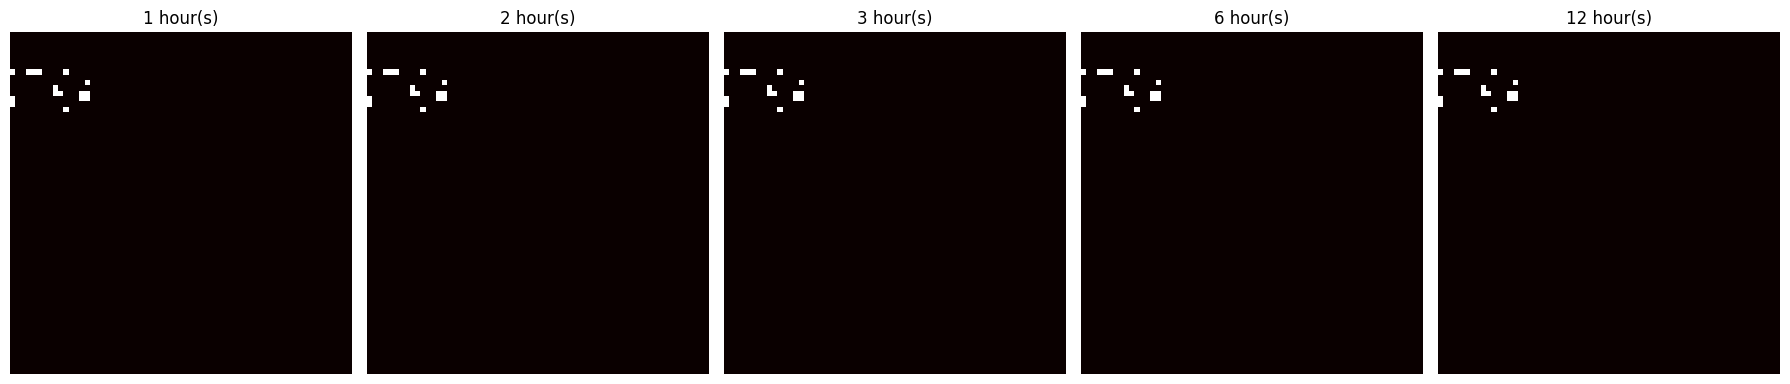

In [84]:
import matplotlib.pyplot as plt

hours = [1, 2, 3, 6, 12]
fig, axs = plt.subplots(1, len(hours), figsize=(18, 4))
for i, h in enumerate(hours):
    axs[i].imshow(fire_sequence[h], cmap='hot')
    axs[i].set_title(f"{h} hour(s)")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

✅ Saved: fire_spread_simulation.gif with 13 frames


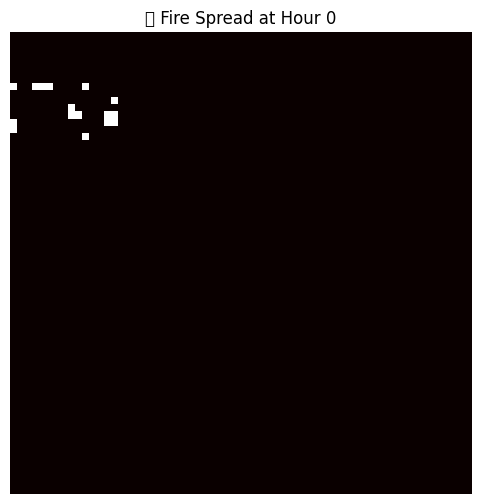

In [86]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 6))

def update(frame):
    ax.clear()
    ax.imshow(fire_sequence[frame], cmap='hot')
    ax.set_title(f"🔥 Fire Spread at Hour {frame}")
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=range(len(fire_sequence)), interval=800)
ani.save("fire_spread_simulation.gif", writer='pillow')
print("✅ Saved: fire_spread_simulation.gif with", len(fire_sequence), "frames")

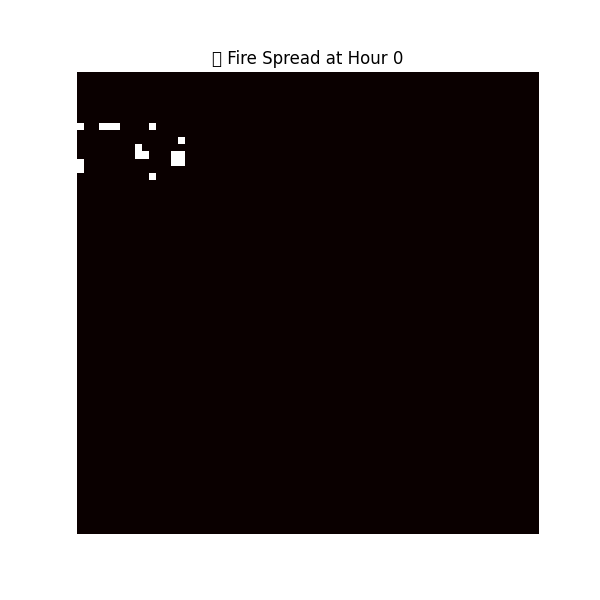

In [87]:
from IPython.display import Image
Image(filename="fire_spread_simulation.gif")

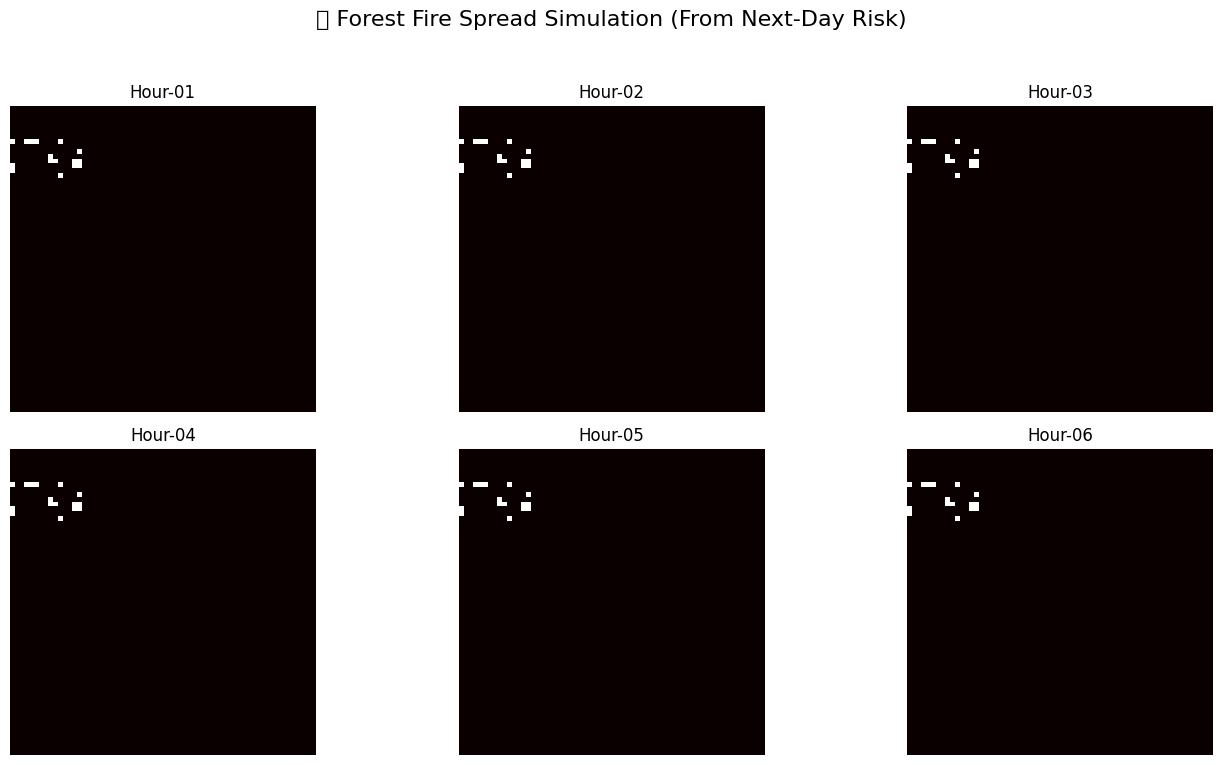

In [88]:
import matplotlib.pyplot as plt

# Display hours 1 to 6
hours = [1, 2, 3, 4, 5, 6]
titles = [f"Hour-{h:02d}" for h in hours]

fig, axs = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle("🔥 Forest Fire Spread Simulation (From Next-Day Risk)", fontsize=16)

for ax, hour, title in zip(axs.ravel(), hours, titles):
    ax.imshow(fire_sequence[hour], cmap='hot')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("fire_spread_summary_layout.png", dpi=300)
plt.show()

In [90]:
ghsl_padded = pad_to_square(ghsl, 64)

📦 Padded to: (64, 64)


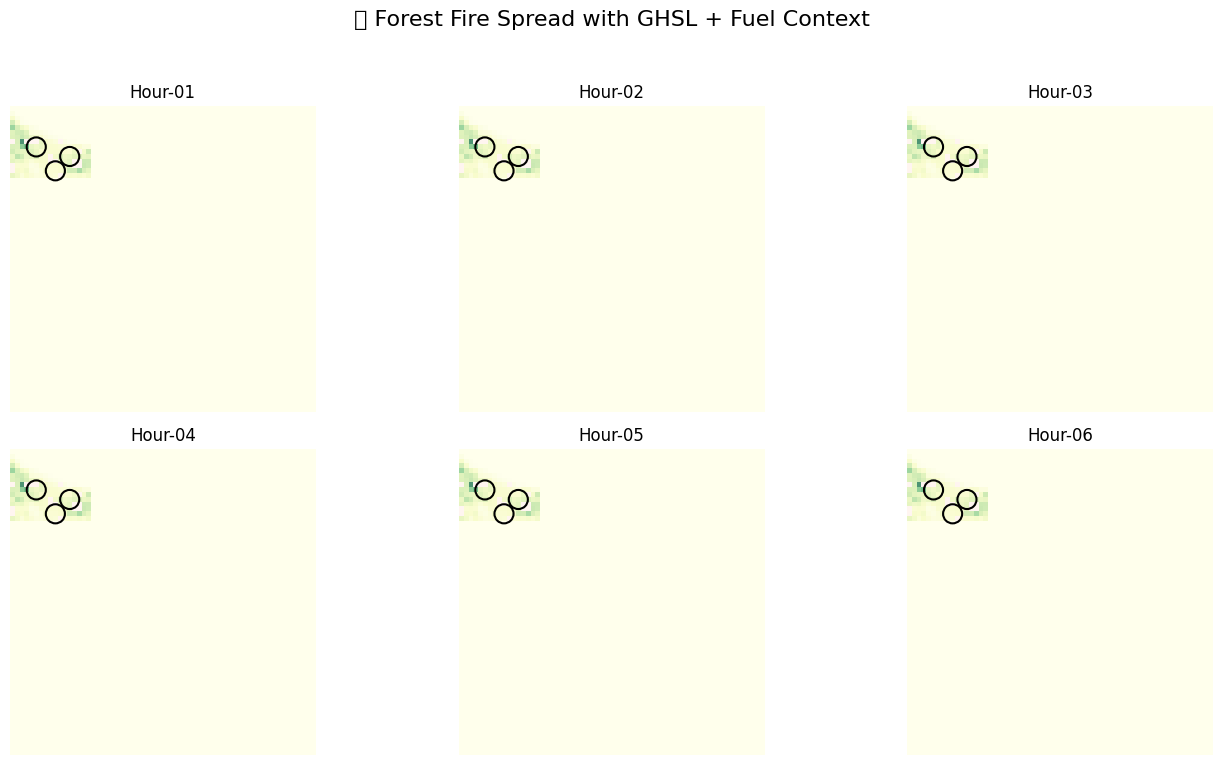

In [93]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ✅ Replace with your actual data
background = np.clip(ghsl_padded + fuel_padded, 0, 1)  # GHSL + LULC-like base

# 🔴 Define hotspot coordinates to annotate (row, col format)
hotspots = [(10, 12), (13, 9), (8, 5)]  # Add more if needed

# 🔥 Fire spread layout
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle("🔥 Forest Fire Spread with GHSL + Fuel Context", fontsize=16)

for i, (ax, hour) in enumerate(zip(axs.ravel(), range(1, 7))):
    ax.imshow(background, cmap='YlGn', alpha=0.7)  # Base layer
    fire_mask = np.ma.masked_where(fire_sequence[hour] == 0, fire_sequence[hour])
    ax.imshow(fire_mask, cmap='Reds', alpha=1.0)
    ax.set_title(f"Hour-{hour:02d}")
    ax.axis('off')

    # ➕ Annotate key hotspots
    for (y, x) in hotspots:
        circle = patches.Circle((x, y), radius=2, linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(circle)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("fire_spread_with_layers.png", dpi=300)
plt.show()

In [97]:
from scipy.signal import convolve2d
import numpy as np

def simulate_fire_spread_debug(fire, fuel, slope, u_wind, v_wind, steps=12):
    print("🧪 Fire Spread Debug Mode ON")
    fire = fire.copy()
    fire_sequence = [fire.copy()]

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    for step in range(steps):
        print(f"\n--- Step {step + 1} ---")

        spread_potential = convolve2d(fire, kernel, mode='same', boundary='fill', fillvalue=0)
        wind_effect = 0.5 * u_wind + 0.5 * v_wind
        terrain_boost = 0.5 * slope + 0.5 * wind_effect

        new_fire = (
            (spread_potential > 0) &
            (fuel > 0.1) &
            (terrain_boost > 0.3) &  # 🔧 adjust this if too strict
            (fire == 0)
        )

        print("🔥 Currently burning:", fire.sum())
        print("🌾 Fuel > 0.0       :", (fuel > 0.0).sum())
        print("🌬️ Wind effect > 0.3:", (terrain_boost > 0.3).sum())
        print("🆕 New fire pixels  :", new_fire.sum())

        fire = fire | new_fire
        fire_sequence.append(fire.copy())

    return fire_sequence

In [98]:
fire_sequence_debug = simulate_fire_spread_debug(
    fire=fire_padded,
    fuel=fuel_padded,
    slope=slope_padded,
    u_wind=u_padded,
    v_wind=v_padded,
    steps=12
)

🧪 Fire Spread Debug Mode ON

--- Step 1 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 2 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 3 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 4 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 5 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 6 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 7 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 8 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 205
🆕 New fire pixels  : 0

--- Step 9 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effec

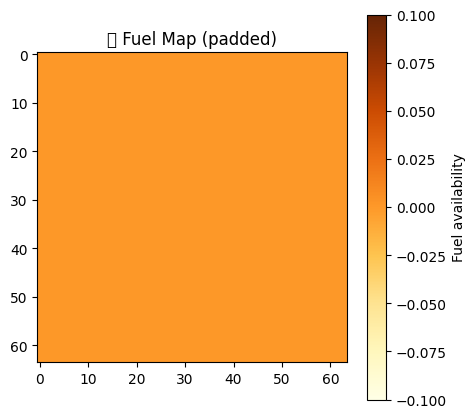

Fuel stats → min: 0.0 max: 0.0 mean: 0.0


In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(fuel_padded, cmap='YlOrBr')
plt.title("🪵 Fuel Map (padded)")
plt.colorbar(label="Fuel availability")
plt.show()

print("Fuel stats → min:", np.min(fuel_padded), "max:", np.max(fuel_padded), "mean:", np.mean(fuel_padded))

In [100]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Load your LULC raster (as categorical)
with rasterio.open(lulc_path) as src, rasterio.open("geotiffs/temperature.tif") as ref:
    lulc_resampled = src.read(
        1,
        out_shape=(ref.height, ref.width),
        resampling=Resampling.nearest  # keep categorical
    )

# Define mapping from LULC class to fuel value
lulc_to_fuel = {
    1: 0.0,  # water
    2: 0.0,  # urban
    3: 0.4,  # agri
    4: 0.6,  # scrub
    5: 1.0,  # dense forest
    6: 0.9,  # open forest
    7: 0.7,  # grassland
    # Add more if needed
}

# Map LULC to fuel using numpy vectorization
fuel = np.zeros_like(lulc_resampled, dtype=np.float32)
for k, v in lulc_to_fuel.items():
    fuel[lulc_resampled == k] = v

# Now pad it for simulation
fuel_padded = pad_to_square(fuel, 64)

# 🔍 Optional: Check
print("✅ New fuel stats →", "min:", fuel_padded.min(), "max:", fuel_padded.max(), "mean:", fuel_padded.mean())

📦 Padded to: (64, 64)
✅ New fuel stats → min: 0.0 max: 0.0 mean: 0.0


In [101]:
import rasterio
import numpy as np

with rasterio.open(lulc_path) as src:
    lulc_raw = src.read(1)

unique_classes = np.unique(lulc_raw)
print("🧾 Unique LULC classes in the raster:", unique_classes)

🧾 Unique LULC classes in the raster: [0]


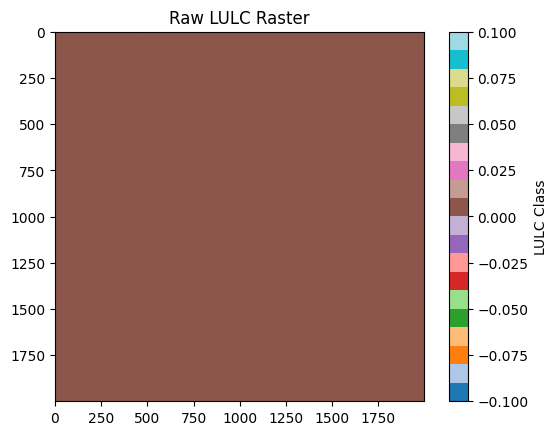

Raw LULC shape: (2000, 2000)
Unique classes: [0]


In [102]:
import matplotlib.pyplot as plt
with rasterio.open(lulc_path) as src:
    lulc_raw = src.read(1)

plt.imshow(lulc_raw, cmap='tab20')
plt.title("Raw LULC Raster")
plt.colorbar(label="LULC Class")
plt.show()

print("Raw LULC shape:", lulc_raw.shape)
print("Unique classes:", np.unique(lulc_raw))


🧪 Fire Mask
  Shape: (64, 64)
  Min: 0 Max: 1 Mean: 0.00390625


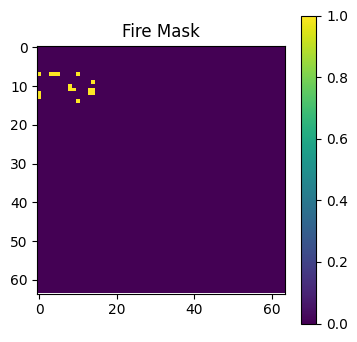


🧪 Fuel
  Shape: (64, 64)
  Min: 0.0 Max: 0.0 Mean: 0.0


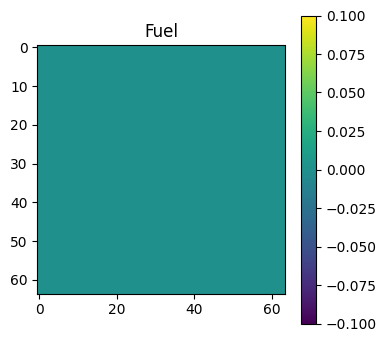


🧪 Slope
  Shape: (64, 64)
  Min: -9999.0 Max: 89.999016 Mean: -117.55516


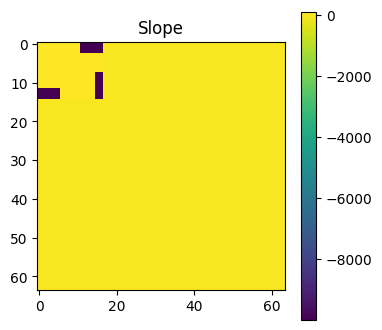


🧪 U-Wind
  Shape: (64, 64)
  Min: -4.597641 Max: 1.3144684 Mean: -0.08452296


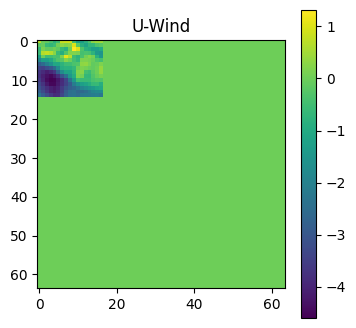


🧪 V-Wind
  Shape: (64, 64)
  Min: -1.6560822 Max: 2.5079803 Mean: 0.01595803


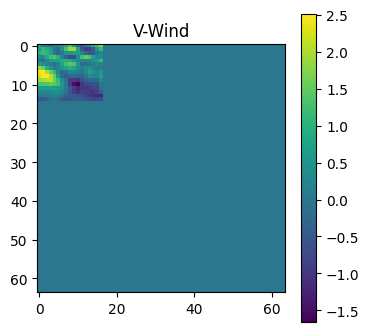


🧪 GHSL
  Shape: (64, 64)
  Min: 0.0 Max: 1.0 Mean: 0.007438290153133903


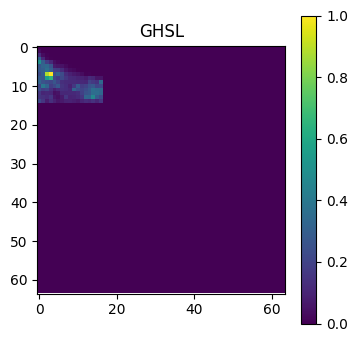

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# ⬇️ Put all your padded inputs here
inputs = {
    "Fire Mask": fire_padded,
    "Fuel": fuel_padded,
    "Slope": slope_padded,
    "U-Wind": u_padded,
    "V-Wind": v_padded,
    "GHSL": ghsl_padded  # if available
}

# 🔍 Visual + statistical checks
for name, arr in inputs.items():
    print(f"\n🧪 {name}")
    print("  Shape:", arr.shape)
    print("  Min:", np.min(arr), "Max:", np.max(arr), "Mean:", np.mean(arr))

    plt.figure(figsize=(4, 4))
    plt.imshow(arr, cmap='viridis')
    plt.title(name)
    plt.colorbar()
    plt.show()

In [104]:
slope_padded = np.where(slope_padded < -1000, 0, slope_padded)

In [105]:
slope_padded = (slope_padded - slope_padded.min()) / (slope_padded.max() - slope_padded.min() + 1e-6)


🧪 Fire Mask
  Shape: (64, 64)
  Min: 0 Max: 1 Mean: 0.00390625


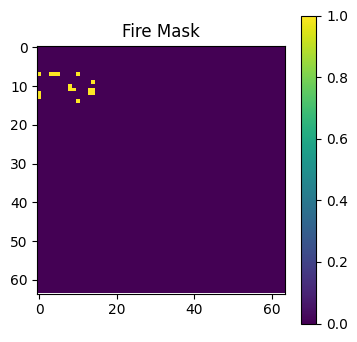


🧪 Fuel
  Shape: (64, 64)
  Min: 0.0 Max: 0.0 Mean: 0.0


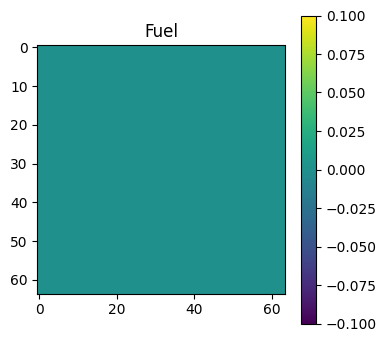


🧪 Slope
  Shape: (64, 64)
  Min: 0.0 Max: 1.0 Mean: 0.05003334


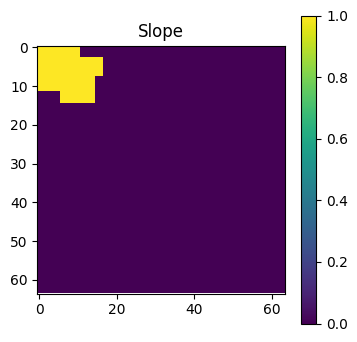


🧪 U-Wind
  Shape: (64, 64)
  Min: -4.597641 Max: 1.3144684 Mean: -0.08452296


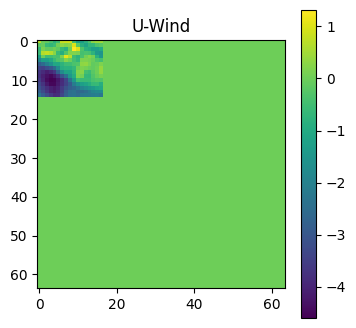


🧪 V-Wind
  Shape: (64, 64)
  Min: -1.6560822 Max: 2.5079803 Mean: 0.01595803


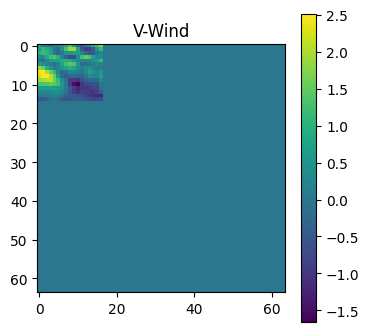


🧪 GHSL
  Shape: (64, 64)
  Min: 0.0 Max: 1.0 Mean: 0.007438290153133903


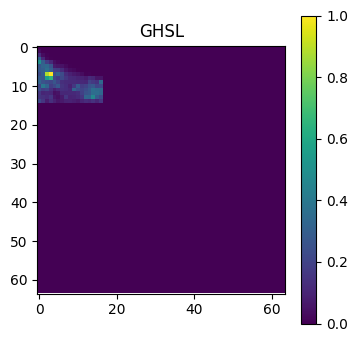

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# ⬇️ Put all your padded inputs here
inputs = {
    "Fire Mask": fire_padded,
    "Fuel": fuel_padded,
    "Slope": slope_padded,
    "U-Wind": u_padded,
    "V-Wind": v_padded,
    "GHSL": ghsl_padded  # if available
}

# 🔍 Visual + statistical checks
for name, arr in inputs.items():
    print(f"\n🧪 {name}")
    print("  Shape:", arr.shape)
    print("  Min:", np.min(arr), "Max:", np.max(arr), "Mean:", np.mean(arr))

    plt.figure(figsize=(4, 4))
    plt.imshow(arr, cmap='viridis')
    plt.title(name)
    plt.colorbar()
    plt.show()

In [107]:
# 🔍 Focus on active region
crop_slice = slice(0, 16)  # adjust as needed

fire_crop = fire_padded[crop_slice, crop_slice]
fuel_crop = fuel_padded[crop_slice, crop_slice]
slope_crop = slope_padded[crop_slice, crop_slice]
u_crop = u_padded[crop_slice, crop_slice]
v_crop = v_padded[crop_slice, crop_slice]

# 🔄 Run simulation (debug version recommended first)
fire_seq_crop = simulate_fire_spread_debug(
    fire=fire_crop,
    fuel=fuel_crop,
    slope=slope_crop,
    u_wind=u_crop,
    v_wind=v_crop,
    steps=12
)

🧪 Fire Spread Debug Mode ON

--- Step 1 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 2 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 3 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 4 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 5 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 6 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 7 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 8 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effect > 0.3: 101
🆕 New fire pixels  : 0

--- Step 9 ---
🔥 Currently burning: 16
🌾 Fuel > 0.0       : 0
🌬️ Wind effec

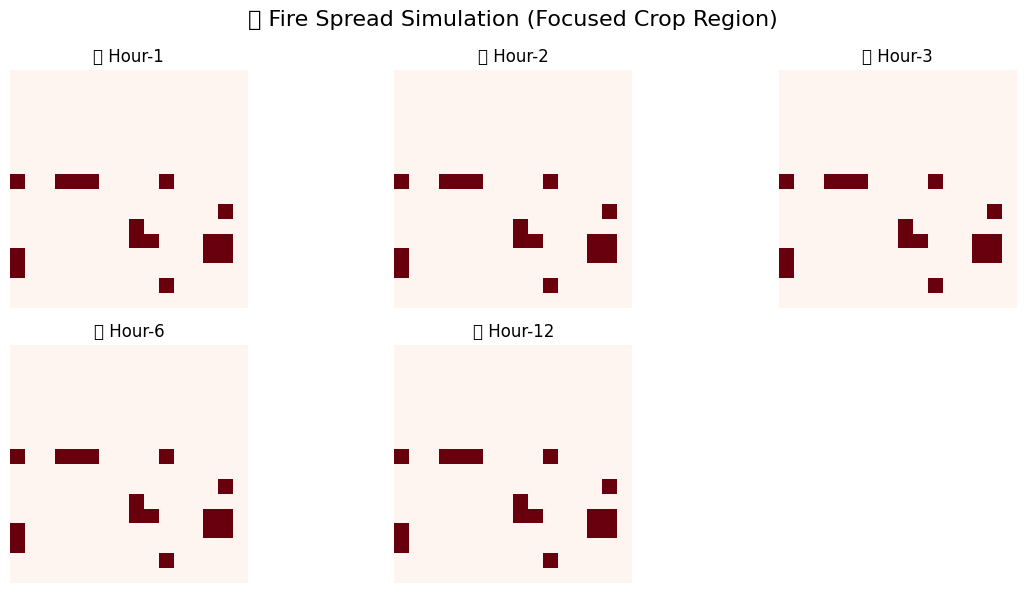

In [108]:
# Visualize spread
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, step in enumerate([1, 2, 3, 6, 12]):
    plt.subplot(2, 3, i+1)
    plt.imshow(fire_seq_crop[step], cmap='Reds')
    plt.title(f"🔥 Hour-{step}")
    plt.axis('off')

plt.suptitle("🔥 Fire Spread Simulation (Focused Crop Region)", fontsize=16)
plt.tight_layout()
plt.show()